
<a id='kalman'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Uma Introdução ao Filtro de Kalman


<a id='index-0'></a>

## Conteúdo

- [Uma Introdução ao Filtro de Kalman](#Uma-Introdução-ao-Filtro-de-Kalman)  
  - [Resumo](#Resumo)  
  - [Idéia Básica](#Idéia-Básica)  
  - [Convergência](#Convergência)  
  - [Implementação](#Implementação)  
  - [Exercícios](#Exercícios)  
  - [Soluções](#Soluções)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://julia.quantecon.org/) pelos bolsistas CNPq Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob a supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

Essa aula provê uma introdução simples e intuitiva ao Filtro de Kalman, para aqueles que:

- Já ouviram falar no Filtrod e Kalman mas não sabem como trabalhá-lo, e  
- Aqueles que conhecem as equações do Filtro de Kalman, mas não sabem de onde elas vieram.  


Para leituras adicionais (mais avançadas)no Filtro de Kalman, veja

- [[LS18]](https://lectures.quantecon.org/zreferences.html#ljungqvist2012), section 2.7.  
- [[AM05]](https://lectures.quantecon.org/zreferences.html#andersonmoore2005)  


A segunda referência apresenta um tratamento compreensível do Filtro de Kalman, requerindo conhecimentos em: manipulação de matrizes, distribuições normais multivariadas, matrizes de variância-covariância, etc.

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics

## Idéia Básica

O Filtro de Kalman tem diversas aplicações na Economia, mas agora, finjamos que somos cientistas que estão criando um foguete.

Um míssil foi lançado do país Y e nossa missão é acompanhá-lo.

Seja $ x  \in \mathbb{R}^2 $ a localização atual do míssil indicando as coordenadas latitude-longitude no mapa.

No presente momento, a localizção precisa $ x $ é desconhecida, mas nós temos algumas crenças sobre $ x $.

Uma maneira de sumarizar nosso conhecimento é a predição de um ponto $ \hat x $.

- Mas e se o presidente quiser saber a probabilidade de que o míssil esteja atualmente sobre o mar do Japão?  
- Assim é melhor sumarizzar nossas crenças iniciais com uma densidade de probabilidade bivariada $ p $:  
  
  - $ \int_E p(x)dx $ indicates the probability that we attach to the missile being in region $ E $  
  


A densidade $ p $ é chamada de *prior* para a variável aleatória $ x $.

Para manter as coisas tratáveis no nosso exemplo, tomaremos como prioridade o Gaussiano. Particularmente:


<a id='equation-prior'></a>
$$
p = N(\hat x, \Sigma) \tag{1}
$$

onde $ \hat x $ é a média da distribuição e $ \Sigma $ é uma matriz de covariância $ 2 \times 2 $. Em nossas simulações, nós iremos supor que:


<a id='equation-kalman-dhxs'></a>
$$
\hat x
= \left(
\begin{array}{c}
    0.2 \\
    -0.2
\end{array}
  \right),
\qquad
\Sigma
= \left(
\begin{array}{cc}
    0.4 & 0.3 \\
    0.3 & 0.45
\end{array}
  \right) \tag{2}
$$

Essa densidade $ p(x) $ é mostrada abaixo como um mapa de contorno, com o centro do ellipse vermelho sendo igual a $ \hat x $

In [3]:
using Plots, Distributions

gr(fmt = :png); # configuração do plot

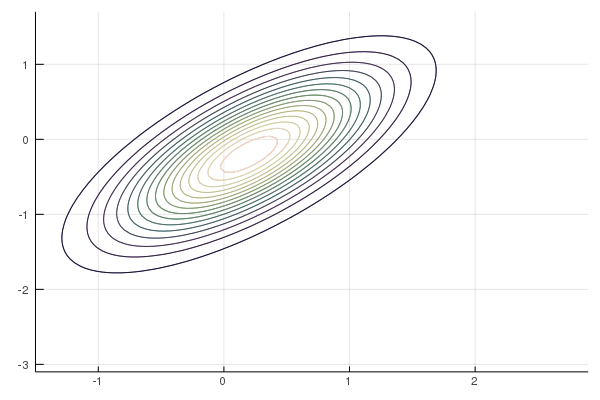

In [4]:
# configurar objetos anteriores
Σ = [0.4  0.3
     0.3  0.45]
x̂ = [0.2, -0.2]

# defina G e R a partir da equação y = Gx + N(0, R)
G = I # este é um objeto de identidade genérico que se adapta às dimensões corretas
R = 0.5 .* Σ

# definindo A e Q
A = [1.2  0
     0   -0.2]
Q = 0.3Σ

y = [2.3, -1.9]

# plotando objetos
x_grid = range(-1.5, 2.9, length = 100)
y_grid = range(-3.1, 1.7, length = 100)

# gerando a distribuição
dist = MvNormal(x̂, Σ)
two_args_to_pdf(dist) = (x, y) -> pdf(dist, [x, y]) # returns a function to be plotted

# plot
contour(x_grid, y_grid, two_args_to_pdf(dist), fill = false,
        color = :lighttest, cbar = false)
contour!(x_grid, y_grid, two_args_to_pdf(dist), fill = false, lw=1,
         color = :grays, cbar = false)

### A filtragem

Agora lhe apresentamos algumas boas e más notícias: a boa é que o míssil foi localizado pelos sensores, que relatou uma localização dada por $ y = (2.3, -1.9) $.

A próxima figura mostra a localização antiga $ p(x) $ e a nova localização relatada $ y $:

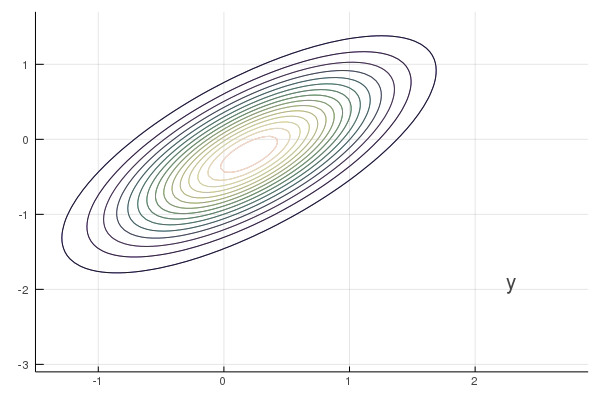

In [5]:
# plot the figure
annotate!(y[1], y[2], "y", color = :black)

As más notícias são que os sensores são imprecisos.

Particularmente, devemos interpretar a resposta do nosso sensor não como $ y=x $, ao invés disso como sendo:


<a id='equation-kl-measurement-model'></a>
$$
y = G x + v, \quad \text{onde} \quad v \sim N(0, R) \tag{3}
$$

Aqui $ G $ e $ R $ são matrizes $ 2 \times 2 $ com $ R $ positiva e definida. Assumimos que ambas são conhecidas, e o termo ruído $ v $ é dado como independente de $ x $.

Então como nós deveremos combinar nosso anterior $ p(x) = N(\hat x, \Sigma) $ com essa nova informação $ y $ para melhor entendimento da localização do míssil?

Como você pode ter adivinhado, a resposta para isso é o uso do Teorema de Bayes, que nos diz para atualizar nosso antecessor $ p(x) $ para $ p(x \,|\, y) $ via

$$
p(x \,|\, y) = \frac{p(y \,|\, x) \, p(x)} {p(y)}
$$

onde $ p(y) = \int p(y \,|\, x) \, p(x) dx $.

Resolvendo para $ p(x \,|\, y) $, nós observamos que

- $ p(x) = N(\hat x, \Sigma) $;  
- Na visão de [(3)](#equation-kl-measurement-model), a densidade condicional $ p(y \,|\, x) $ é $ N(Gx, R) $;  
- $ p(y) $ não depende de $ x $, e entra nos cálculos apenas como uma constante normalizadora.  


Dado que estamos em uma estrutura linear e gaussiana, a densidade atualizada pode ser computada pelo cálculo das regressões lineares populacionais.

Em particular, a solução é conhecida como <sup><a href=#f1 id=f1-link>[1]</a></sup>, sendo

$$
p(x \,|\, y) = N(\hat x^F, \Sigma^F)
$$

onde


<a id='equation-kl-filter-exp'></a>
$$
\hat x^F := \hat x + \Sigma G' (G \Sigma G' + R)^{-1}(y - G \hat x)
\quad \text{e} \quad
\Sigma^F := \Sigma - \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma \tag{4}
$$

Aqui, $ \Sigma G' (G \Sigma G' + R)^{-1} $ é a matriz dos coeficientes de regressão populacional do objeto escondido $ x - \hat x $ na surpresa $ y - G \hat x $.

Essa nova densidade $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ é mostrada na próxima figura via linhas de contorno e mapas coloridos.

A densidade original é deixada nas linhas de contorno para comparação.

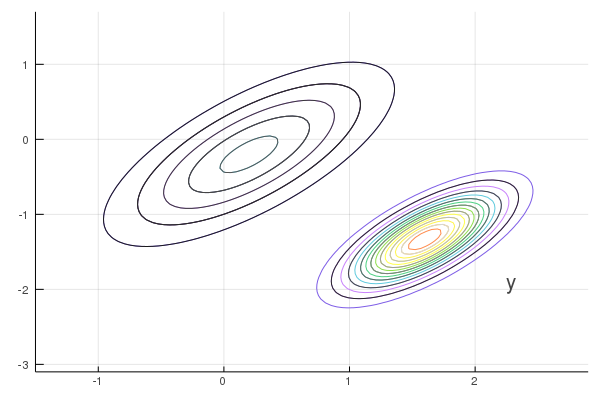

In [6]:
# definir objetos posteriores
M = Σ * G' * inv(G * Σ * G' + R)
x̂_F = x̂ + M * (y - G * x̂)
Σ_F = Σ - M * G * Σ

# plote a nova densidade no plot antigo
newdist = MvNormal(x̂_F, Symmetric(Σ_F)) # porque Σ_F
contour!(x_grid, y_grid, two_args_to_pdf(newdist), fill = false,
         color = :lighttest, cbar = false)
contour!(x_grid, y_grid, two_args_to_pdf(newdist), fill = false, levels = 7,
         color = :grays, cbar = false)
contour!(x_grid, y_grid, two_args_to_pdf(dist), fill = false, levels = 7, lw=1,
         color = :grays, cbar = false)

Nossa nova densidade torce a anterior $ p(x) $ em uma direção determinada pela nova informação $ y - G \hat x $.

Gerando a figura, montamos $ G $ como uma matriz identidade e $ R = 0.5 \Sigma $ para $ \Sigma $ definido em [(2)](#equation-kalman-dhxs).


<a id='kl-forecase-step'></a>

### A etapa de previsão

O que temos nós alcançado tão longe? 

Nós obtivemos probabilidades para a localização atual do estado (míssil) dadas as informações anteriores e atuais.

Isso é chamado de “filtragem” ao invés de previsão, porquê nós estamos filtrando ruídos ao invés de procurar no futuro.

- $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ é denominada *distribuição filtrada*.  


Porém, agora vamos supor que foi dada outra tarefa: predizer a localização do míssil após uma unidade de tempo (qualquer que seja) que já passou.

Para fazer isso, nós necessitamos de um modelo que mostre como o estado evolui.

Vamo supor que nós temos um, que é linear e gaussiano. Particularmente,


<a id='equation-kl-xdynam'></a>
$$
x_{t+1} = A x_t + w_{t+1}, \quad \text{onde} \quad w_t \sim N(0, Q) \tag{5}
$$

Nosso foco é combinar essa lei de movmento e nossa distribuição atual $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ vir com uma nova distribuição *preditiva* para ser localizada em uma unidade de tempo.

Na visão de [(5)](#equation-kl-xdynam), tudo o que nós temos de fazer é introduzir um vetor aleatório $ x^F \sim N(\hat x^F, \Sigma^F) $ e trabalhar a distribuição $ A x^F + w $, onde $ w $ é independente de $ x^F $ e tem uma distribuição $ N(0, Q) $.

Desde que as combinações lineares gaussianas o sejam, $ A x^F + w $ é gaussiana.

Cálculos elementares e a expressão em [(4)](#equation-kl-filter-exp) nos diz que

$$
\mathbb{E} [A x^F + w]
= A \mathbb{E} x^F + \mathbb{E} w
= A \hat x^F
= A \hat x + A \Sigma G' (G \Sigma G' + R)^{-1}(y - G \hat x)
$$

e

$$
\operatorname{Var} [A x^F + w]
= A \operatorname{Var}[x^F] A' + Q
= A \Sigma^F A' + Q
= A \Sigma A' - A \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma A' + Q
$$

A matriz $ A \Sigma G' (G \Sigma G' + R)^{-1} $ é frequentemente escrita como $ K_{\Sigma} $ e denominada *ganho de Kalman*.

- O subscrito $ \Sigma $ foi adicionado para nos lembrar que  $ K_{\Sigma} $ depende de $ \Sigma $, mas não $ y $ ou $ \hat x $  


Usando essa notação, podemos sumarizar os resultados.

Nossa predição atualizada é a densidade $ N(\hat x_{new}, \Sigma_{new}) $ onde


<a id='equation-kl-mlom0'></a>
$$
\begin{aligned}
    \hat x_{new} &:= A \hat x + K_{\Sigma} (y - G \hat x) \\
    \Sigma_{new} &:= A \Sigma A' - K_{\Sigma} G \Sigma A' + Q \nonumber
\end{aligned} \tag{6}
$$

- A densidade $ p_{new}(x) = N(\hat x_{new}, \Sigma_{new}) $ é chamada de *distribuição preditiva*.  


A distribuição preditiva é a nova densidade mostrada na figura seguinte, onde a atualização usa os parâmetros

$$
A
= \left(
\begin{array}{cc}
    1.2 & 0.0 \\
    0.0 & -0.2
\end{array}
  \right),
  \qquad
Q = 0.3 * \Sigma
$$

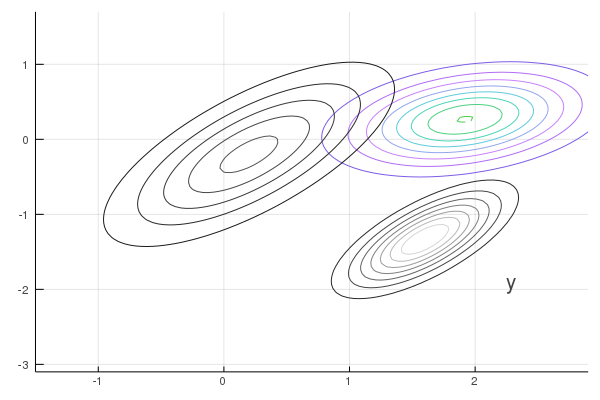

In [7]:
# obtenha a distribuição preditiva
new_x̂ = A * x̂_F
new_Σ = A * Σ_F * A' + Q
predictdist = MvNormal(new_x̂, Symmetric(new_Σ))

# plote Density 3
contour(x_grid, y_grid, two_args_to_pdf(predictdist), fill = false, lw = 1,
        color = :lighttest, cbar = false)
contour!(x_grid, y_grid, two_args_to_pdf(dist),
         color = :grays, cbar = false)
contour!(x_grid, y_grid, two_args_to_pdf(newdist), fill = false, levels = 7,
         color = :grays, cbar = false)
annotate!(y[1], y[2], "y", color = :black)

### Procedimento recursivo


<a id='index-1'></a>
Vamos olhar para trás e ver o que fizemos.

Começamos o período atual com um $ p(x) $ anterior para a localização $ x $ do míssil.

Então usamos a mensuração corrente $ y $ para atualizar pra $ p(x \,|\, y) $.

Finalmente, usamos a lei da moção [(5)](#equation-kl-xdynam) para $ \{x_t\} $ para atualizar pra $ p_{new}(x) $.

Se dermos um passo em direção ao próximo período, estaremos prontos para dar a volta de novo, tomando $ p_{new}(x) $
como o atual anterior.

Trocando a notação $ p_t(x) $ por $ p(x) $ e $ p_{t+1}(x) $ por $ p_{new}(x) $, o procedimento recursivo total é:

1. Começar o período atual com o anterior $ p_t(x) = N(\hat x_t, \Sigma_t) $;  
2. Observar a mensuração atual $ y_t $;  
3. Computar a distribuição filtrada $ p_t(x \,|\, y) = N(\hat x_t^F, \Sigma_t^F) $ de $ p_t(x) $ e $ y_t $, aplicando a Regra de Bayes e a distribuição condicional [(3)](#equation-kl-measurement-model);  
4. Compute a distribuição preditiva $ p_{t+1}(x) = N(\hat x_{t+1}, \Sigma_{t+1}) $ da distribuição filtrada e [(5)](#equation-kl-xdynam); e  
5. Incremente $ t $ por um e volte ao passo 1.  


Repetindo [(6)](#equation-kl-mlom0), a dinâmica para $ \hat x_t $ e $ \Sigma_t $ é como se segue:


<a id='equation-kalman-lom'></a>
$$
\begin{aligned}
    \hat x_{t+1} &= A \hat x_t + K_{\Sigma_t} (y_t - G \hat x_t) \\
    \Sigma_{t+1} &= A \Sigma_t A' - K_{\Sigma_t} G \Sigma_t A' + Q \nonumber
\end{aligned} \tag{7}
$$

Essas são equações dinâmicas padrões para o Filtro de Kalman (veja, por exemplo, [[LS18]](https://lectures.quantecon.org/zreferences.html#ljungqvist2012), page 58).


<a id='kalman-convergence'></a>

## Convergência

A matriz $ \Sigma_t $ é uma medida da incerteza da nossa predição $ \hat x_t $ de $ x_t $.

À parte de casos especiais, essa incerteza nunca será totalmente resolvida, independente de quanto tempo decorra.

Uma razão é que nossa predição $ \hat x_t $ é feita com base em informações disponíveis em $ t-1 $, not $ t $.

Mesmo se nós soubéssemos o valor preciso de $ x_{t-1} $ (o que não sabemos), a equação de transição [(5)](#equation-kl-xdynam) implica que $ x_t = A x_{t-1} + w_t $.

Desde que o choque $ w_t $ não seja observável em $ t-1 $, em qualquer tempo $ t-1 $ a predição de $ x_t $ irá incorrer em algum erro (a menos que $ w_t $ seja degenerado).

Porém, é certamente possível que $ \Sigma_t $ convirja para uma matriz constante como $ t \to \infty $.

Para estudar esse tópico, vamos expandir a segunda equação em [(7)](#equation-kalman-lom):


<a id='equation-kalman-sdy'></a>
$$
\Sigma_{t+1} = A \Sigma_t A' -  A \Sigma_t G' (G \Sigma_t G' + R)^{-1} G \Sigma_t A' + Q \tag{8}
$$

Isso é uma equação diferencial não-linear em $ \Sigma_t $.

Um ponto fixo de [(8)](#equation-kalman-sdy) é uma matriz constante de $ \Sigma $ tal que:


<a id='equation-kalman-dare'></a>
$$
\Sigma = A \Sigma A' -  A \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma A' + Q \tag{9}
$$

A equação [(8)](#equation-kalman-sdy) é conhecida como equação diferencial de Riccati em tempo discreto.

Já a equação [(9)](#equation-kalman-dare) é conhecida como uma [equação algébrica de Riccati em tempo discreto](https://en.wikipedia.org/wiki/Algebraic_Riccati_equation).

Condições sob as quais existe um ponto fixo e se $ \{\Sigma_t\} $ converge serão discutidos em [[AHMS96]](https://lectures.quantecon.org/zreferences.html#ahms1996) and [[AM05]](https://lectures.quantecon.org/zreferences.html#andersonmoore2005), capítulo 4.

Uma condição suficiente (mas não necessária) é que os autovalores $ \lambda_i $ de $ A $ satisfaçam $ |\lambda_i| < 1 $ (cf. e.g., [[AM05]](https://lectures.quantecon.org/zreferences.html#andersonmoore2005), p. 77).

(essa pesada condição assegura que a distribuição incondicional de $ x_t $ converge como $ t \rightarrow + \infty $).

Nesse caso, para qualquer escolha inicial de $ \Sigma_0 $ que seja simétrica e não-negativa, a sequência $ \{\Sigma_t\} $ em [(8)](#equation-kalman-sdy) converge para uma matriz simétrica não-negativa $ \Sigma $ que resolve [(9)](#equation-kalman-dare).

## Implementação


<a id='index-2'></a>
O pacote [QuantEcon.jl](http://quantecon.org/julia_index.html) está disponível para implementar o Filtro de Kalman por métodos denominados `Kalman`

- A instância dos dados consiste em:  
  
  - Parâmetros $ A, G, Q, R $ de um dado modelo; e  
  - Os momentos $ (\hat x_t, \Sigma_t) $ do atual anterior.  
  
- O tipo `Kalman` do pacote [QuantEcon.jl](http://quantecon.org/julia_index.html) tem um conjunto de métodos, alguns dos quais nós iremos esperar para usar até estudar métodos mais avançados nos estudos subsequentes.  
- Os métodos pertinentes para essa leitura são:  
  
  - `prior_to_filtered`, o que atuliza $ (\hat x_t, \Sigma_t) $ to $ (\hat x_t^F, \Sigma_t^F) $; 
  - `filtered_to_forecast`, o que atualiza a distribuição filtrada para a distribuição preditiva – o que se torna o novo antecessor $ (\hat x_{t+1}, \Sigma_{t+1}) $;  
  - `update`, o que combina os últimos dois métodos; e  
  - a `stationary_values`, o que computa a solução de [(9)](#equation-kalman-dare) e o correspondente (stationary)ganho de Kalman.
  


Você pode visualizar o programa [no GitHub](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/kalman.jl).

## Exercícios


<a id='kalman-ex1'></a>

### Exercício 1

Considere a seguinte (e simples) aplicação do Filtro de Kalman, vagarosamente baseado
em [[LS18]](https://lectures.quantecon.org/zreferences.html#ljungqvist2012), seção 2.9.2.

Suponha que

- Todas as variáveis são escalares  
- O estado escondido $ \{x_t\} $ é de fato constante, igual a algum $ \theta \in \mathbb{R} $ desconhecido ao modelo.  


A dinâmica do estado é, portanto, dada por [(5)](#equation-kl-xdynam) com $ A=1 $, $ Q=0 $ e $ x_0 = \theta $.

A equação de mensuração é $ y_t = \theta + v_t $ onde $ v_t $ é $ N(0,1) $ e iid.

A tarefa desse exercício é simular esse modelo e, usando o código `kalman.jl`, plotar as cinco primeiras densidades preditivas $ p_t(x) = N(\hat x_t, \Sigma_t) $.

Como mostrado em [[LS18]](https://lectures.quantecon.org/zreferences.html#ljungqvist2012), seções 2.9.1–2.9.2, essas distribuições assintoticamente no valor desconhecido $ \theta $.

Na simulação tome $ \theta = 10 $, $ \hat x_0 = 8 $ e $ \Sigma_0 = 1 $.
 
Sua figura deverá – modulo aleatoriedade – mostrar algo como isso:

<img src="https://julia.quantecon.org/tools_and_techniques/_static/figures/kl_ex1_fig.png" style="width:70%;">

<a id='kalman-ex2'></a>

### Exercício 2

A figura precedente fornece algum apoio a idéia de que a massa de probabilidae converge para $ \theta $.

Para se ter uma melhor idéia, escolha um $ \epsilon > 0 $ pequeno e calcule.

$$
z_t := 1 - \int_{\theta - \epsilon}^{\theta + \epsilon} p_t(x) dx
$$

para $ t = 0, 1, 2, \ldots, T $

Plote $ z_t $ contra $ T $, configurando $ \epsilon = 0.1 $ and $ T = 600 $.

Sua figura deverá mostrar erro ao recusar erraticamente algo como isso:

<img src="https://julia.quantecon.org/tools_and_techniques/_static/figures/kl_ex2_fig.png" style="width:70%;">

  

<a id='kalman-ex3'></a>

### Exercício 3

Como discutido [acima](#kalman-convergence), se a sequência-choque $ \{w_t\} $ não é degenerada, então não há uma possibilidade geral para predizer $ x_t $ sem erro na hora. $ t-1 $ (e assim poderia ser caso pudéssemos obeservar $ x_{t-1} $).

Vamos agora comparar a predição $ \hat x_t $ feita pelo Filtro de Kalman contra um competidor a quem **é** permitido observar $ x_{t-1} $.

Esse competidor irá usar a expectativa condicional $ \mathbb E[ x_t \,|\, x_{t-1}] $, que nesse caso é $ A x_{t-1} $.

A expectativa condicional é conhecida por ser um método de predição ótima em termos de minimizar a média dos quadrados dos erros.

(mais precisamente, a minimização de $ \mathbb E \, \| x_t - g(x_{t-1}) \|^2 $ com respeito a $ g $ is $ g^*(x_{t-1}) := \mathbb E[ x_t \,|\, x_{t-1}] $)

Portsnto, nós estamos comparando o Filtro de Kalman contra um competidor que tem mais informações (no sentido de estar disponível a observar o estado latente) e otimizar o comportamento em termos de minimizar os quadrados dos erros.

Nosso cavalo de corrida será avaliado em termos de quadrados dos erros.

Particularmente, sua tarefa é gerar um gráfico plotando observações de ambos $ \| x_t - A x_{t-1} \|^2 $ e $ \| x_t - \hat x_t \|^2 $ contra $ t $ para $ t = 1, \ldots, 50 $.

Para os parâmetros, defina $ G = I, R = 0.5 I $ e $ Q = 0.3 I $, onde $ I $ é a identidade $ 2 \times 2 $.

Seja

$$
A
= \left(
\begin{array}{cc}
    0.5 & 0.4 \\
    0.6 & 0.3
\end{array}
  \right)
$$

Para inicializar a identidade anterior, defina

$$
\Sigma_0
= \left(
\begin{array}{cc}
    0.9 & 0.3 \\
    0.3 & 0.9
\end{array}
  \right)
$$

e $ \hat x_0 = (8, 8) $.

Finalmente, defina $ x_0 = (0, 0) $

Você deverá finalizar com uma figura semelhante a essa (módulo aleatoriedade):

<img src="https://julia.quantecon.org/tools_and_techniques/_static/figures/kalman_ex3.png" style="width:50%;">

  
Observe como, após um período de aprendizagem inicial, o Filtro de Kalman executa bem, mesmo em relação ao competidor que prediz otimamente com o conhecimento do estado latente.


<a id='kalman-ex4'></a>

### Exercício 4

Tente variar o coeficiente $ 0.3 $ em $ Q = 0.3 I $ de alto a baixo.

Observe como os valores da diagonal na solução estacionária $ \Sigma $ (see [(9)](#equation-kalman-dare)) aumentam e diminuem na linha com esse coeficiente.

A interpretação é que mais aleatoriedade na lei de moção para $ x_t $ causa (permanentemente) mais incerteza na predição.

## Soluções

In [8]:
using QuantEcon

### Exercício 1

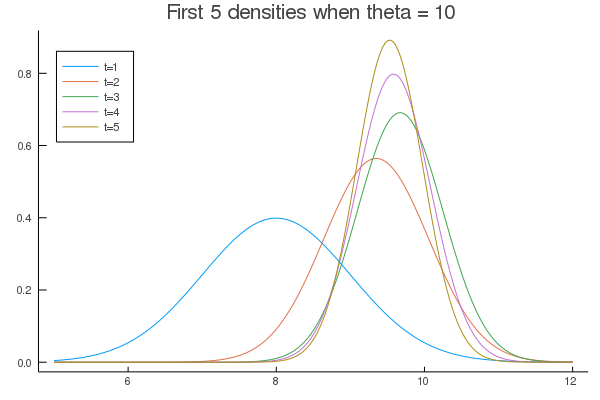

In [9]:
# parâmetros
θ = 10
A, G, Q, R = 1.0, 1.0, 0.0, 1.0
x̂_0, Σ_0 = 8.0, 1.0

# Inicializando o filtro de Kalman 
kalman = Kalman(A, G, Q, R)
set_state!(kalman, x̂_0, Σ_0)

xgrid = range(θ - 5, θ + 2, length = 200)
densities = zeros(200, 5) # uma coluna por rodada de atualização
for i in 1:5
    # registrar a média e variância previstas atuais e plotar suas densidades
    m, v = kalman.cur_x_hat, kalman.cur_sigma
    densities[:, i] = pdf.(Normal(m, sqrt(v)), xgrid)

    # gerar o sinal barulhento
    y = θ + randn()

    # atualize o filtro Kalman
    update!(kalman, y)
end

labels = ["t=1", "t=2", "t=3", "t=4", "t=5"]
plot(xgrid, densities, label = labels, legend = :topleft, grid = false,
     title = "First 5 densities when theta = $θ")

### Exercício 2

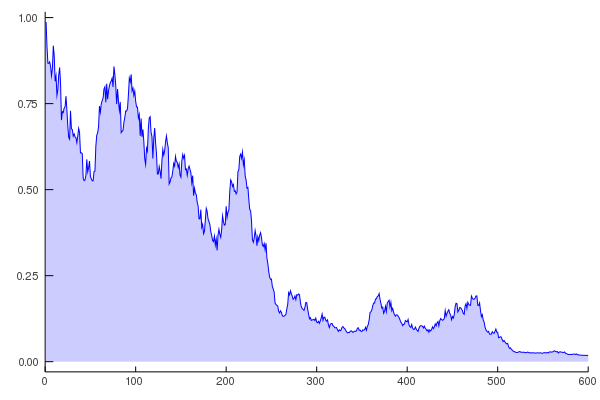

In [10]:
using Random, Expectations
Random.seed!(43)  # resultados reproduzíveis
ϵ = 0.1
kalman = Kalman(A, G, Q, R)
set_state!(kalman, x̂_0, Σ_0)
nodes, weights = qnwlege(21, θ-ϵ, θ+ϵ)

T = 600
z = zeros(T)
for t in 1:T
    # registrar a média e variância previstas atuais e plotar suas densidades
    m, v = kalman.cur_x_hat, kalman.cur_sigma
    dist = Truncated(Normal(m, sqrt(v)), θ-30*ϵ, θ+30*ϵ) # definir em intervalo compacto, para que possamos usar expectativa em grade
    E = expectation(dist, nodes) # nós ∈ [θ-ϵ, θ+ϵ]
    integral = E(x -> 1) # basta pegar a integral em fdp
    z[t] = 1. - integral
    # gere o sinal ruidoso e atualize o filtro Kalman
    update!(kalman, θ + randn())
end

plot(1:T, z, fillrange = 0, color = :blue, fillalpha = 0.2, grid = false, xlims=(0, T),
     legend = false)

### Exercise 3

Eigenvalues of A:
[-0.10000000000000003, 0.8999999999999999]
Stationary prediction error variance:
[0.4032910794778669 0.10507180275061759; 0.1050718027506176 0.41061709375220456]


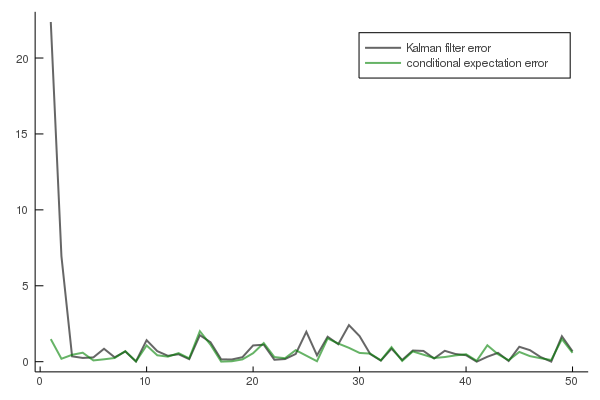

In [11]:
# defina A, Q, G, R
G = I + zeros(2, 2)
R = 0.5 .* G
A = [0.5 0.4
        0.6 0.3]
Q = 0.3 .* G

# defina a densidade anterior
Σ = [0.9 0.3
        0.3 0.9]
x̂ = [8, 8]

# inicialize o filtro de Kalman
kn = Kalman(A, G, Q, R)
set_state!(kn, x̂, Σ)

# defina o verdadeiro valor inicial do estado
x = zeros(2)

# imprima autovalores de A
println("Eigenvalues of A:\n$(eigvals(A))")

# imprima o estacionário Σ
S, K = stationary_values(kn)
println("Stationary prediction error variance:\n$S")

# gere o plot
T = 50
e1 = zeros(T)
e2 = similar(e1)
for t in 1:T

    # gerar sinal e atualizar previsão
    dist = MultivariateNormal(G * x, R)
    y = rand(dist)
    update!(kn, y)

    # estado de atualização e erro de registro
    Ax = A * x
    x = rand(MultivariateNormal(Ax, Q))
    e1[t] = sum((a - b)^2 for (a, b) in zip(x, kn.cur_x_hat))
    e2[t] = sum((a - b)^2 for (a, b) in zip(x, Ax))
end

plot(1:T, e1, color = :black, linewidth = 2, alpha = 0.6, label = "Kalman filter error",
     grid = false)
plot!(1:T, e2, color = :green, linewidth = 2, alpha = 0.6,
      label = "conditional expectation error")

**Notas de rodape**

<p><a id=f1 href=#f1-link><strong>[1]</strong></a> ´Veja, por exemplo, página 93 de [[Bis06]](https://lectures.quantecon.org/zreferences.html#bishop2006). Para passar das suas expressões para as usadas acima, você irá precisar também aplicar a [matriz-identidade de Woodbury](https://en.wikipedia.org/wiki/Woodbury_matrix_identity).